<div style="background-color: pink; padding: 15px;">
ECON 470 Homework 2


Author: Ellen Wu

</div>

In [1]:
# Importing the libraries 
# Import libraries
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn.neighbors import NearestNeighbors
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')

#Read output datasets
HCRIS_Data = pd.read_csv('/Users/ellenwu/homework2-2/data/output/HCRIS_Data.csv')
HCRISv1996 = pd.read_csv('/Users/ellenwu/homework2-2/data/output/HCRIS_v1996.csv')
HCRISv2010 = pd.read_csv('/Users/ellenwu/homework2-2/data/output/HCRIS_v2010.csv')

\new page

1. How many hospitals filed more than one report in the same year? Show your answer as a line graph of the number of hospitals over time.

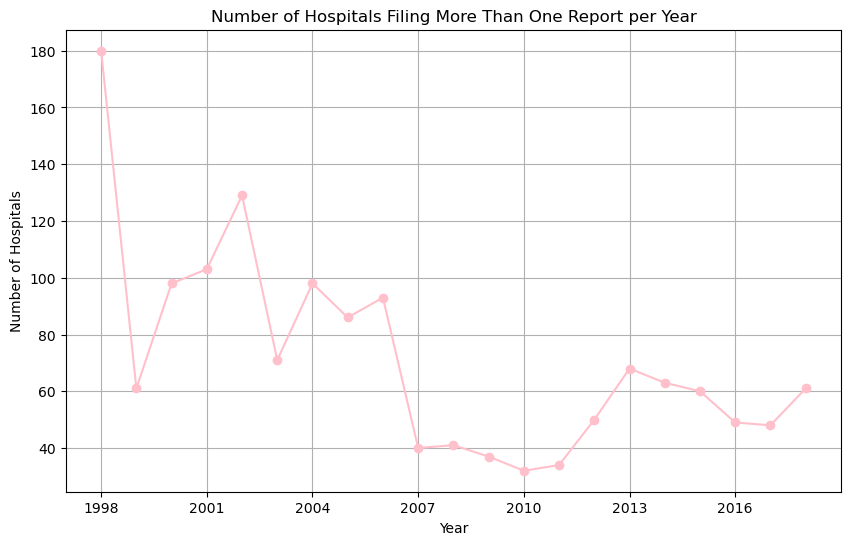

In [2]:
# Count the number of reports per hospital per year
report_counts = HCRIS_Data.groupby(['year', 'provider_number']).size().reset_index(name='report_count')

# Filter hospitals that filed more than one report in the same year
multiple_reports = report_counts[report_counts['report_count'] > 1]

# Count the number of hospitals per year with multiple reports
hospitals_per_year = multiple_reports.groupby('year').size().reset_index(name='num_hospitals')

# Plot the result as a line graph
plt.figure(figsize=(10, 6))
plt.plot(hospitals_per_year['year'], hospitals_per_year['num_hospitals'], marker='o', linestyle='-', color='pink')
plt.title('Number of Hospitals Filing More Than One Report per Year')
plt.xticks(ticks=hospitals_per_year['year'].astype(int), labels=hospitals_per_year['year'].astype(int))
years = hospitals_per_year['year'].astype(int)
plt.xticks(ticks=years[::3], labels=years[::3])
plt.xlabel('Year')
plt.ylabel('Number of Hospitals')
plt.grid(True)
plt.show()

\new page

2. After removing/combining multiple reports, how many unique hospital IDs (Medicare provider numbers) exist in the data?

In [3]:
unique_hospital_ids = HCRIS_Data['provider_number'].nunique()
print(f'The number of unique hospital IDs is: {unique_hospital_ids}')

The number of unique hospital IDs is: 9382


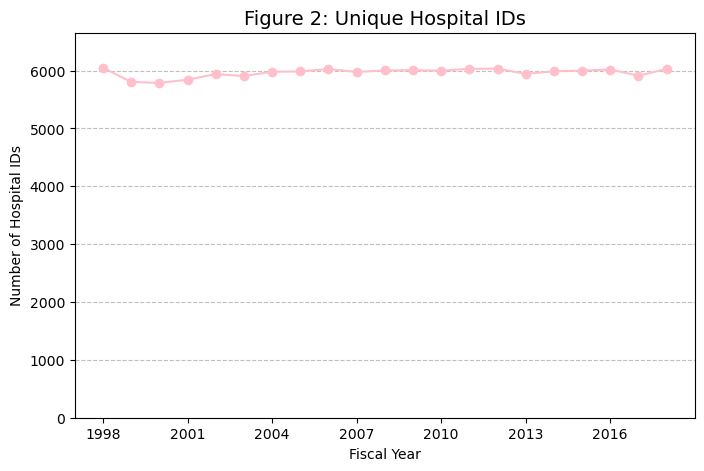

In [4]:
hosp_count = HCRIS_Data.groupby('year').size().reset_index(name='hosp_count')

# Count of unique hospitals per year
plt.figure(figsize=(8, 5))
plt.plot(hosp_count['year'].values, hosp_count['hosp_count'].values,
         marker='o', linestyle='-', color='pink')
plt.title('Figure 2: Unique Hospital IDs', fontsize=14)
plt.xticks(ticks=hospitals_per_year['year'].astype(int), labels=hospitals_per_year['year'].astype(int))
years = hospitals_per_year['year'].astype(int)
plt.xticks(ticks=years[::3], labels=years[::3])
plt.xlabel('Fiscal Year')
plt.ylabel('Number of Hospital IDs')
plt.ylim(0, hosp_count['hosp_count'].max() * 1.1)
plt.grid(axis='y', color='gray', linestyle='--', alpha=0.5)
plt.show()

\new page

3. What is the distribution of total charges (tot_charges in the data) in each year? Show your results with a “violin” plot, with charges on the y-axis and years on the x-axis. 

In [5]:
# Filter and preprocess data
charge_data = HCRIS_Data.copy()

#Compute 1st and 99th percentile for total charges per year
charge_data['tot_charges_low'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x,1))
charge_data['tot_charges_high'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x,99))

#Filter out extreme values and missing data
charge_data = charge_data[
    (charge_data['tot_charges'] > charge_data['tot_charges_low']) &
    (charge_data['tot_charges'] < charge_data['tot_charges_high']) &
    charge_data['tot_charges'].notna() & 
    (charge_data['year'] > 1997)
]

#compute log of total charges
charge_data['log_charge'] = np.log(charge_data['tot_charges'])

#Prepare data for violin
years = sorted(charge_data['year'].unique())
data = [charge_data[charge_data['year'] == y]['log_charge'].dropna().values for y in years]

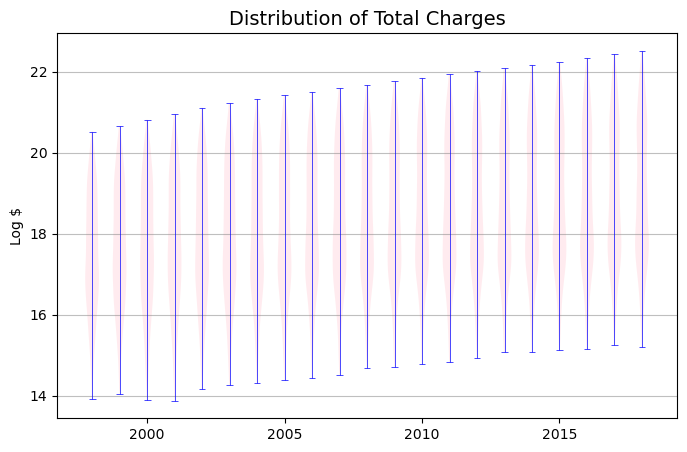

In [7]:
#plot distribution of total charges
fig, ax= plt.subplots(figsize = (8,5))
parts = ax.violinplot(data, positions= years, showmedians= False)

#customize violin plot 
for pc in parts ['bodies']:
    pc.set_facecolor('pink')
    pc.set_alpha (0.3)

for part in ['cbars','cmins', 'cmaxes']:
    parts[part].set_color('blue')
    parts[part].set_linewidth(0.5)

#format plot 
plt.title('Distribution of Total Charges', fontsize= 14)
plt. xlabel('')
plt.ylabel('Log \$')
plt. grid (axis = 'y', color = 'gray', linestyle = '-', alpha = 0.5)
plt.show()

\new page

4. What is the distribution of estimated prices in each year? Again present your results with a violin plot, and recall our formula for estimating prices from class. Be sure to do something about outliers and/or negative prices in the data.

In [8]:
#Compute price data
HCRIS_Data['discount_factor'] = 1 - HCRIS_Data['tot_discounts']/HCRIS_Data['tot_charges']
HCRIS_Data['price_num'] = (
    (HCRIS_Data['ip_charges'] + HCRIS_Data['icu_charges'] + HCRIS_Data['ancillary_charges']) *
    HCRIS_Data['discount_factor']
) - HCRIS_Data ['tot_mcare_payment']
HCRIS_Data['price_denom'] = HCRIS_Data['tot_discharges'] - HCRIS_Data['mcare_discharges']
HCRIS_Data['price'] = HCRIS_Data['price_num'] / HCRIS_Data['price_denom']

#Data filtering
price_data = HCRIS_Data[
    (HCRIS_Data['price_denom'] > 100) &
    (~HCRIS_Data['price_denom'].isna()) &
    (HCRIS_Data['price_num'] > 0) &
    (~HCRIS_Data['price_num'].isna()) &
    (HCRIS_Data['price'] < 100000) &
    (HCRIS_Data['beds'] > 30) &
    (~HCRIS_Data['beds'].isna())
]

# Data preparation 
years= sorted(price_data['year'].unique())
data = [price_data[price_data['year'] == year]['price'].dropna().values for year in years]

ValueError: zero-size array to reduction operation minimum which has no identity

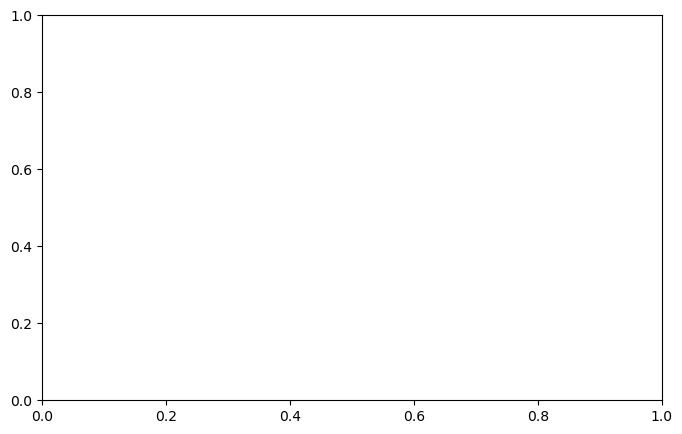

In [10]:
#plot distribution of hospital prices
fig, ax= plt.subplots(figsize = (8,5))
parts = ax.violinplot(data, positions= years, showmedians= False)

#customize violin plot 
for pc in parts ['bodies']:
    pc.set_facecolor('pink')
    pc.set_alpha (0.3)

#format plot 
plt.ylim(0,30000)
plt.title('Distribution of Hospital Prices', fontsize= 14)
plt. xlabel('')
plt.ylabel('Price')
plt. grid (axis = 'y', color = 'pink', linestyle = '-', alpha = 0.5)
plt.show()

5. Calculate the average price among penalized versus non-penalized hospitals.

In [11]:
# Load dataset
HCRIS_Data = pd.read_csv('/Users/ellenwu/homework2-2/data/output/HCRIS_Data.csv')

# Filter data to only include year 2012
hcris_2012 = HCRIS_Data[HCRIS_Data['year'] == 2012].copy()

# Handle missing payments
hcris_2012['hvbp_payment'] = hcris_2012['hvbp_payment'].fillna(0)
hcris_2012['hrrp_payment'] = hcris_2012['hrrp_payment'].fillna(0).abs()

# Calculate estimated price
hcris_2012['discount_factor'] = 1 - (hcris_2012['tot_discounts'] / hcris_2012['tot_charges'])
hcris_2012['price_num'] = (hcris_2012['ip_charges'] + hcris_2012['icu_charges'] + hcris_2012['ancillary_charges']) * hcris_2012['discount_factor'] - hcris_2012['tot_mcare_payment']
hcris_2012['price_denom'] = hcris_2012['tot_discharges'] - hcris_2012['mcare_discharges']
hcris_2012['price'] = hcris_2012['price_num'] / hcris_2012['price_denom']

# Define penalty
hcris_2012['penalty'] = (hcris_2012['hrrp_payment'] + hcris_2012['hvbp_payment']) < 0

# Apply data cleaning filters
hcris_2012 = hcris_2012[(hcris_2012['price_denom'] > 100) & (hcris_2012['price_num'] > 0) & (hcris_2012['price'] > 0)]
hcris_2012 = hcris_2012[hcris_2012['beds'] > 30]
hcris_2012 = hcris_2012[hcris_2012['price'] < 100000]  

# Calculate mean price for penalized vs non-penalized hospitals
mean_penalized = hcris_2012.loc[hcris_2012['penalty'] == 1, 'price'].mean()
mean_non_penalized = hcris_2012.loc[hcris_2012['penalty'] == 0, 'price'].mean()

# Create formatted results
price_summary = pd.DataFrame({
    "Penalty Status": ["Penalized", "Non-Penalized"],
    "Average Price": [f"${mean_penalized:,.2f}", f"${mean_non_penalized:,.2f}"]
})

# Sample DataFrame for price summary
price_summary = pd.DataFrame({
    "Penalty Status": ["Penalized", "Non-Penalized"],
    "Average Price": [10171.54, 9651.82]
})

# Save table as Markdown
md_table = price_summary.to_markdown(index=False)
with open("results/table1_penalty_status.md", "w") as f:
    f.write("#### **Table 1: Avg. Price for Penalty Status**\n\n")
    f.write(md_table)

# Save table as LaTeX for PDF conversion
latex_table = price_summary.to_latex(index=False, escape=False, column_format="ll")
with open("results/table1_penalty_status.tex", "w") as f:
    f.write("\\section*{Table 1: Avg. Price for Penalty Status}\n")
    f.write(latex_table)

# Display table in Notebook (for Jupyter)
display(Markdown("#### **Table 1: Avg. Price for Penalty Status**"))
display(Markdown(md_table))

#### **Table 1: Avg. Price for Penalty Status**

| Penalty Status   |   Average Price |
|:-----------------|----------------:|
| Penalized        |        10171.5  |
| Non-Penalized    |         9651.82 |

6. Provide a table of the average price among treated/control groups for each quartile.

In [12]:
# Ensure pen_data_2012 is defined and contains necessary columns
if 'pen_data_2012' not in globals() or pen_data_2012.empty:
    pen_data_2012 = price_data[price_data['year'] == 2012].copy()
    pen_data_2012['penalty'] = ((pen_data_2012['hvbp_payment'].fillna(0) - pen_data_2012['hrrp_payment'].fillna(0).abs()) < 0).astype(int)
    beds_q1 = pen_data_2012['beds'].quantile(0.25)
    beds_q2 = pen_data_2012['beds'].quantile(0.50)
    beds_q3 = pen_data_2012['beds'].quantile(0.75)
    beds_q4 = pen_data_2012['beds'].max()
    pen_data_2012['bed_quart'] = np.select(
        [
            pen_data_2012['beds'] < beds_q1,
            (pen_data_2012['beds'] >= beds_q1) & (pen_data_2012['beds'] < beds_q2),
            (pen_data_2012['beds'] >= beds_q2) & (pen_data_2012['beds'] < beds_q3),
            (pen_data_2012['beds'] > beds_q3) & (pen_data_2012['beds'] <= beds_q4),
        ],
        [1, 2, 3, 4],
        default=0
    )
    pen_data_2012 = pen_data_2012[pen_data_2012['bed_quart'] > 0]

pen_data_2012['beds_quartile'] = pd.qcut(pen_data_2012['beds'], 4, labels=[1, 2, 3, 4])

# Create indicator variables for each quartile
for i in range(1, 5):
    pen_data_2012[f'quartile_{i}'] = (pen_data_2012['beds_quartile'] == i).astype(int)


# Calculate average price for treated and control groups within each quartile
Avg_per_group = []
for i in range(1, 5):
    treated_mean = pen_data_2012.loc[(pen_data_2012[f'quartile_{i}'] == 1) & (pen_data_2012['penalty'] == 1), 'price'].mean()
    control_mean = pen_data_2012.loc[(pen_data_2012[f'quartile_{i}'] == 1) & (pen_data_2012['penalty'] == 0), 'price'].mean()
    Avg_per_group.append({'Quartile': i, 'Penalized Avg. Price': round(treated_mean, 2), 'Non Penalized Avg. Price': round(control_mean, 2)})

results_df = pd.DataFrame(Avg_per_group)
results_df[['Penalized Avg. Price', 'Non Penalized Avg. Price']] = results_df[
    ['Penalized Avg. Price', 'Non Penalized Avg. Price']
].applymap(lambda x: f"${x:,.2f}")

# Ensure "results" directory exists
os.makedirs("results", exist_ok=True)

# Save table as Markdown
md_table = results_df.to_markdown(index=False)
with open("results/table2_avg_price_quartiles.md", "w") as f:
    f.write("#### **Table 2: Avg. Price Among Treated & Control Groups**\n\n")
    f.write(md_table)

# Save table as LaTeX for PDF conversion
latex_table = results_df.to_latex(index=False, escape=False, column_format="lcc")
with open("results/table2_avg_price_quartiles.tex", "w") as f:
    f.write("\\section*{Table 2: Avg. Price Among Treated & Control Groups}\n")
    f.write(latex_table)

# Display table in Notebook (for Jupyter)
display(Markdown("#### **Table 2: Avg. Price Among Treated & Control Groups**"))
display(Markdown(md_table))

#### **Table 2: Avg. Price Among Treated & Control Groups**

|   Quartile | Penalized Avg. Price   | Non Penalized Avg. Price   |
|-----------:|:-----------------------|:---------------------------|
|          1 | $7,277.14              | $7,759.76                  |
|          2 | $8,877.66              | $8,638.68                  |
|          3 | $10,036.28             | $9,521.91                  |
|          4 | $12,690.44             | $12,193.30                 |

In [25]:
#Create bed quartile dummies for models
bed_quarts = pd.get_dummies(pen_data_2012['bed_quart'],prefix='bed_quart').iloc[:, :-1] * 1
bed_quarts = bed_quarts.sub(bed_quarts.mean(axis=0), axis = 1)

# Ensure data is formatted correctly
pen_data_2012['penalty'] = pen_data_2012['penalty'].astype(int)  # Ensure binary treatment variable

# Initialize CausalModel correctly
cm = CausalModel(
    data=pen_data_2012,         # Pass the entire DataFrame
    treatment='penalty',        # Treatment variable
    outcome='price',            # Outcome variable
    common_causes=list(bed_quarts.columns)  # Covariates (bed quartiles)
)

# Display the causal graph (optional)
cm.view_model()

results= pd.DataFrame(index=['ATE', 'SE'], columns= ['INV, MAH', 'IPW', 'OLS'])
cm.est_via_matching(weights='inv', matches=1, bias_adj= True)
results.loc['ATE','INV'] = cm.estimates['matching']['ate']
results.loc['SE','INV'] = cm.estimates['matching']['ate_se']

cm.est_via_matching(weights='maha', matches=1, bias_adj= True)
results.loc['ATE','MAH'] = cm.estimates['matching']['ate']
results.loc['SE','MAH'] = cm.estimates['matching']['ate_se']

cm.est_propensity()
cm.est_via_weighting()
results.loc['ATE','IPW'] = cm.estimates['weighting']['ate']
results.loc['SE','MAH'] = cm.estimates['weighting']['ate_se']

cm.est_via_ols(adj=2)
results.loc['ATE','OLS'] = cm.estimates['ols']['ate']
results.loc['SE','OLS'] = cm.estimates['ols']['ate_se']

results = results.astype(float).round(2)
display(Markdown(results.to_markdown()))

NameError: name 'CausalModel' is not defined

In [13]:
# Ensure data is formatted correctly
price_data['beds'] = pd.to_numeric(price_data['beds'], errors='coerce')
price_data['price'] = pd.to_numeric(price_data['price'], errors='coerce')

# Compute penalty data
price_data['penalty'] = ((price_data['hvbp_payment'].fillna(0) - price_data['hrrp_payment'].fillna(0).abs()) < 0).astype(int)

# Filter data for year 2012
pen_data_2012 = price_data[price_data['year'] == 2012].copy()

# Compute quartiles
beds_q1 = pen_data_2012['beds'].quantile(0.25)
beds_q2 = pen_data_2012['beds'].quantile(0.50)
beds_q3 = pen_data_2012['beds'].quantile(0.75)
beds_q4 = pen_data_2012['beds'].max()

# Assign bed quartiles
pen_data_2012['bed_quart'] = np.select(
    [
        pen_data_2012['beds'] < beds_q1,
        (pen_data_2012['beds'] >= beds_q1) & (pen_data_2012['beds'] < beds_q2),
        (pen_data_2012['beds'] >= beds_q2) & (pen_data_2012['beds'] < beds_q3),
        (pen_data_2012['beds'] > beds_q3) & (pen_data_2012['beds'] <= beds_q4),
    ],
    [1, 2, 3, 4],
    default=0
)

# Filter out invalid quartile values
pen_data_2012 = pen_data_2012[pen_data_2012['bed_quart'] > 0]

# Create bed quartile dummies for models
bed_quarts = pd.get_dummies(pen_data_2012['bed_quart'], prefix='bed_quart').iloc[:, :-1] * 1
bed_quarts = bed_quarts.sub(bed_quarts.mean(axis=0), axis=1)

# Ensure data is formatted correctly
pen_data_2012['penalty'] = pen_data_2012['penalty'].astype(int)  # Ensure binary treatment variable

# Initialize CausalModel correctly
cm = CausalModel(
    data=pen_data_2012,         # Pass the entire DataFrame
    treatment='penalty',        # Treatment variable
    outcome='price',            # Outcome variable
    common_causes=list(bed_quarts.columns)  # Covariates (bed quartiles)
)

# Display the causal graph (optional)
cm.view_model()

results = pd.DataFrame(index=['ATE', 'SE'], columns=['INV', 'MAH', 'IPW', 'OLS'])

# Nearest neighbor matching (1-to-1) with inverse variance distance
cm.est_via_matching(weights='inv', matches=1, bias_adj=True)
results.loc['ATE', 'INV'] = cm.estimates['matching']['ate']
results.loc['SE', 'INV'] = cm.estimates['matching']['ate_se']

# Nearest neighbor matching (1-to-1) with Mahalanobis distance
cm.est_via_matching(weights='maha', matches=1, bias_adj=True)
results.loc['ATE', 'MAH'] = cm.estimates['matching']['ate']
results.loc['SE', 'MAH'] = cm.estimates['matching']['ate_se']

# Inverse propensity weighting
cm.est_propensity()
cm.est_via_weighting()
results.loc['ATE', 'IPW'] = cm.estimates['weighting']['ate']
results.loc['SE', 'IPW'] = cm.estimates['weighting']['ate_se']

# Simple linear regression
cm.est_via_ols(adj=2)
results.loc['ATE', 'OLS'] = cm.estimates['ols']['ate']
results.loc['SE', 'OLS'] = cm.estimates['ols']['ate_se']

results = results.astype(float).round(2)
display(results)

NameError: name 'CausalModel' is not defined

In [73]:
from dowhy import CausalModel
import pandas as pd

# Ensure treatment variable is correctly formatted
pen_data_2012['penalty'] = pen_data_2012['penalty'].astype(int)

# Initialize CausalModel correctly
cm = CausalModel(
    data=pen_data_2012,
    treatment='penalty',
    outcome='price',
    common_causes=list(bed_quarts.columns)
)

# Identify the effect
identified_estimand = cm.identify_effect()

# Estimate effect using Matching (Replaces est_via_matching)
estimate_matching = cm.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching"
)

# Estimate effect using Weighting (Replaces est_via_weighting)
estimate_weighting = cm.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting"
)

# Estimate effect using OLS (Replaces est_via_ols)
estimate_ols = cm.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

# Store results in DataFrame
results = pd.DataFrame(index=['ATE'], columns=['Matching', 'Weighting', 'OLS'])
results.loc['ATE', 'Matching'] = estimate_matching.value
results.loc['ATE', 'Weighting'] = estimate_weighting.value
results.loc['ATE', 'OLS'] = estimate_ols.value

# Display results
from IPython.display import display, Markdown
display(Markdown(results.to_markdown()))

Exception: No common causes/confounders present. Propensity score based methods are not applicable